In [14]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import technical_analysis.backtest_kz as bt
from technical_analysis.indicators import Indicators 
from data_pipelines.data_manipulation import DataManipulation
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

SYMBOL = 'BTC-USD'
SYMBOL_NAME = 'Bitcoin'
SYMBOL_CUT = 'btc'
scale = 1
range_list = [5,6,7,8,10,15,20]
range_list = [i*scale for i in range_list]
period = '2y'
interval = '1d'
start_date = ''
end_data = ''
source = 'yahoo'

data = DataManipulation(SYMBOL, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..', saved_to_csv=True)
df_price = data.df.copy()

[*********************100%***********************]  1 of 1 completed
Start TA-LIB module
created indicators columns with TA-LIB


In [15]:
tr_sh = bt.bt_threshold(df_price, 'rsi_10', 70, 30)
tr_sh.head()

,entry_time,exit_time,entry_price,exit_price,entry_ind,exit_ind,pnl_percent,pnl_cash
0,2021-04-22,2021-07-26,51762.2734,37337.5352,28.2631,71.7217,-0.2787,720.3272
1,2021-09-21,2021-10-05,40693.6758,51514.8125,29.0906,70.1834,0.2659,985.5238
2,2021-12-04,2022-02-07,49200.7031,43840.2852,26.2967,70.8370,-0.1090,875.5882
3,2022-02-21,2022-03-27,37075.2812,46820.4922,29.8804,75.5714,0.2628,1137.5619
4,2022-04-11,2022-10-26,39521.9023,20770.4414,28.2343,72.2552,-0.4745,661.9669


In [16]:
ext_df = data.extract_features()

In [17]:
import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer

client_twitter = TwitterCollection()
df_btc_tweets = client_twitter.get_tweets_df(SYMBOL_NAME, pathdf=f'../data/tweets_data/{SYMBOL_CUT}/', filedf=f'{SYMBOL_CUT}_tweets.csv')

tsa = TweetSentimentAnalyzer(df_btc_tweets)
df = tsa.cleaning_tweet_data(df_btc_tweets)
df = tsa.preprocessing_tweet_datetime(df)
df = tsa.get_sentiment_scores(df)
tsa.add_datetime_to_col(df)
df_result = tsa.get_sent_with_mean_interval(df, interval='1d')
ext_df = tsa.concat_ohlc_compound_score(ext_df, df_result)

Authentication Successfull


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [31]:
ext_df.dropna(inplace=True)
X = ext_df.copy()
X.reset_index(inplace=True, drop=True)
X.drop(columns=['feature_label'], axis=1, inplace=True)
Y = ext_df.feature_label.copy()
Y = Y.reset_index(drop=True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=46)

In [33]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

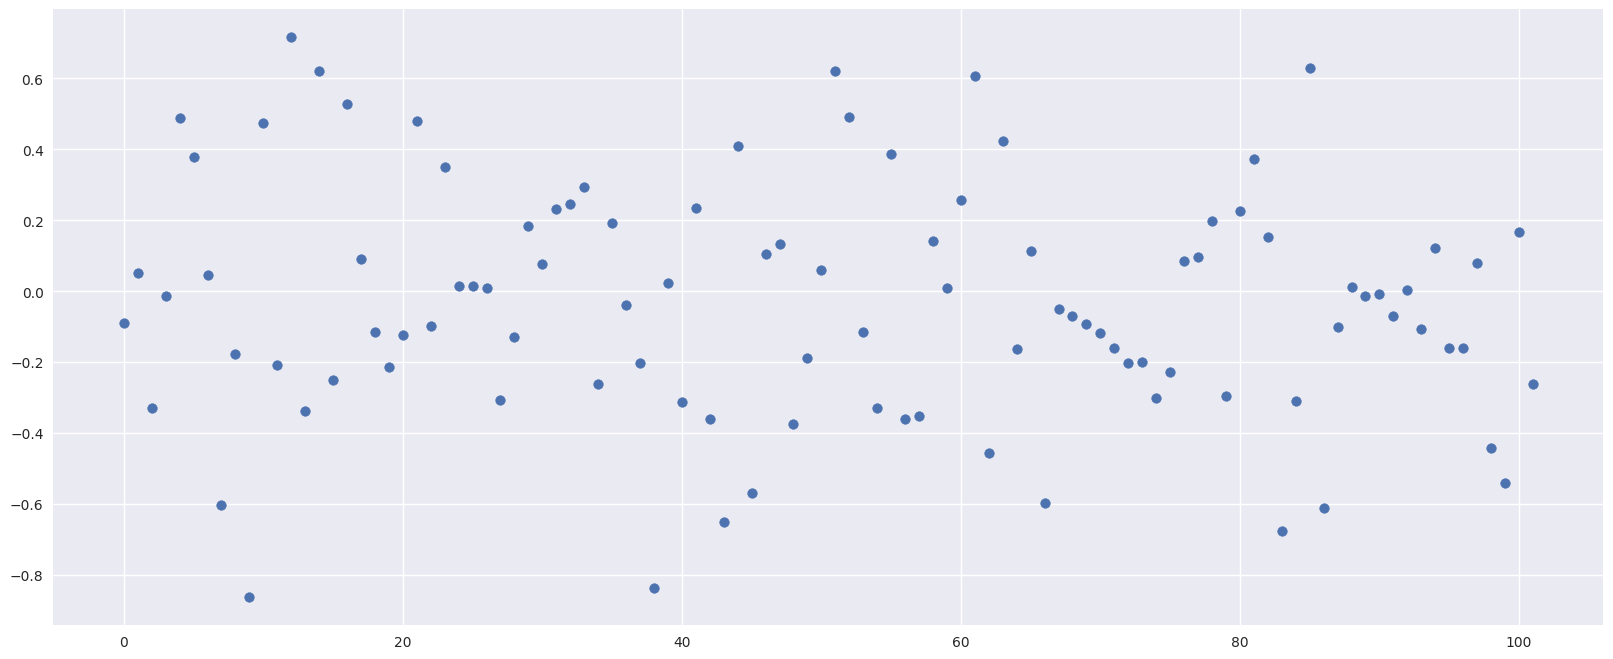

In [34]:
import matplotlib.pyplot as plt
import numpy as np
weigths = model.coef_
fig, ax = plt.subplots(1,1, figsize=(20,8))
plt.scatter(np.arange(0,len(np.column_stack(weigths).ravel())), np.column_stack(weigths).ravel())

In [35]:
np.column_stack(weigths).ravel().size

102

In [36]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [37]:
model = Sequential(
    [               
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=16, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ], name = "my_model" 
)   

2022-12-04 23:41:50.163478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-04 23:41:50.231207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-04 23:41:50.231275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-04 23:41:50.232676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [38]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13184     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,065
Trainable params: 24,065
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train, y_train,
    epochs=40
)

Epoch 1/40
16/16 [==============================] - 2s 6ms/step - loss: 0.7043
Epoch 2/40
16/16 [==============================] - 0s 6ms/step - loss: 0.6897
Epoch 3/40
16/16 [==============================] - 0s 5ms/step - loss: 0.6940
Epoch 4/40
16/16 [==============================] - 0s 6ms/step - loss: 0.6828
Epoch 5/40
16/16 [==============================] - 0s 5ms/step - loss: 0.6751
Epoch 6/40
16/16 [==============================] - 0s 5ms/step - loss: 0.6729
Epoch 7/40
16/16 [==============================] - 0s 5ms/step - loss: 0.6751
Epoch 8/40
16/16 [==============================] - 0s 5ms/step - loss: 0.6593
Epoch 9/40
16/16 [==============================] - 0s 5ms/step - loss: 0.6482
Epoch 10/40
16/16 [==============================] - 0s 5ms/step - loss: 0.6392
Epoch 11/40
16/16 [==============================] - 0s 6ms/step - loss: 0.6257
Epoch 12/40
16/16 [==============================] - 0s 6ms/step - loss: 0.6223
Epoch 13/40
16/16 [==============================

In [40]:
pred = model.predict(X_test)
pred = (pred >= 0.5).astype(int)
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)
print(f'Confusion Matrix: {confusion_matrix(y_test, pred)}')
print(f'Accuracy Score {accuracy_score(y_test, pred)}')

4/4 [==============================] - 0s 3ms/step
Evaluate on test data
1/1 [==============================] - 0s 103ms/step - loss: 1.6231
test loss, test acc: 1.623090386390686
Confusion Matrix: [[34 24]
 [29 36]]
Accuracy Score 0.5691056910569106


In [41]:
pd.DataFrame(pred).value_counts()

0    63
1    60
dtype: int64

In [42]:
# CALCULATE KZ_INDEX/SCORE
ext_df['kz_score'] = ext_df.sum(axis = 1)

Text(0.5, 1.0, 'KZ Index')

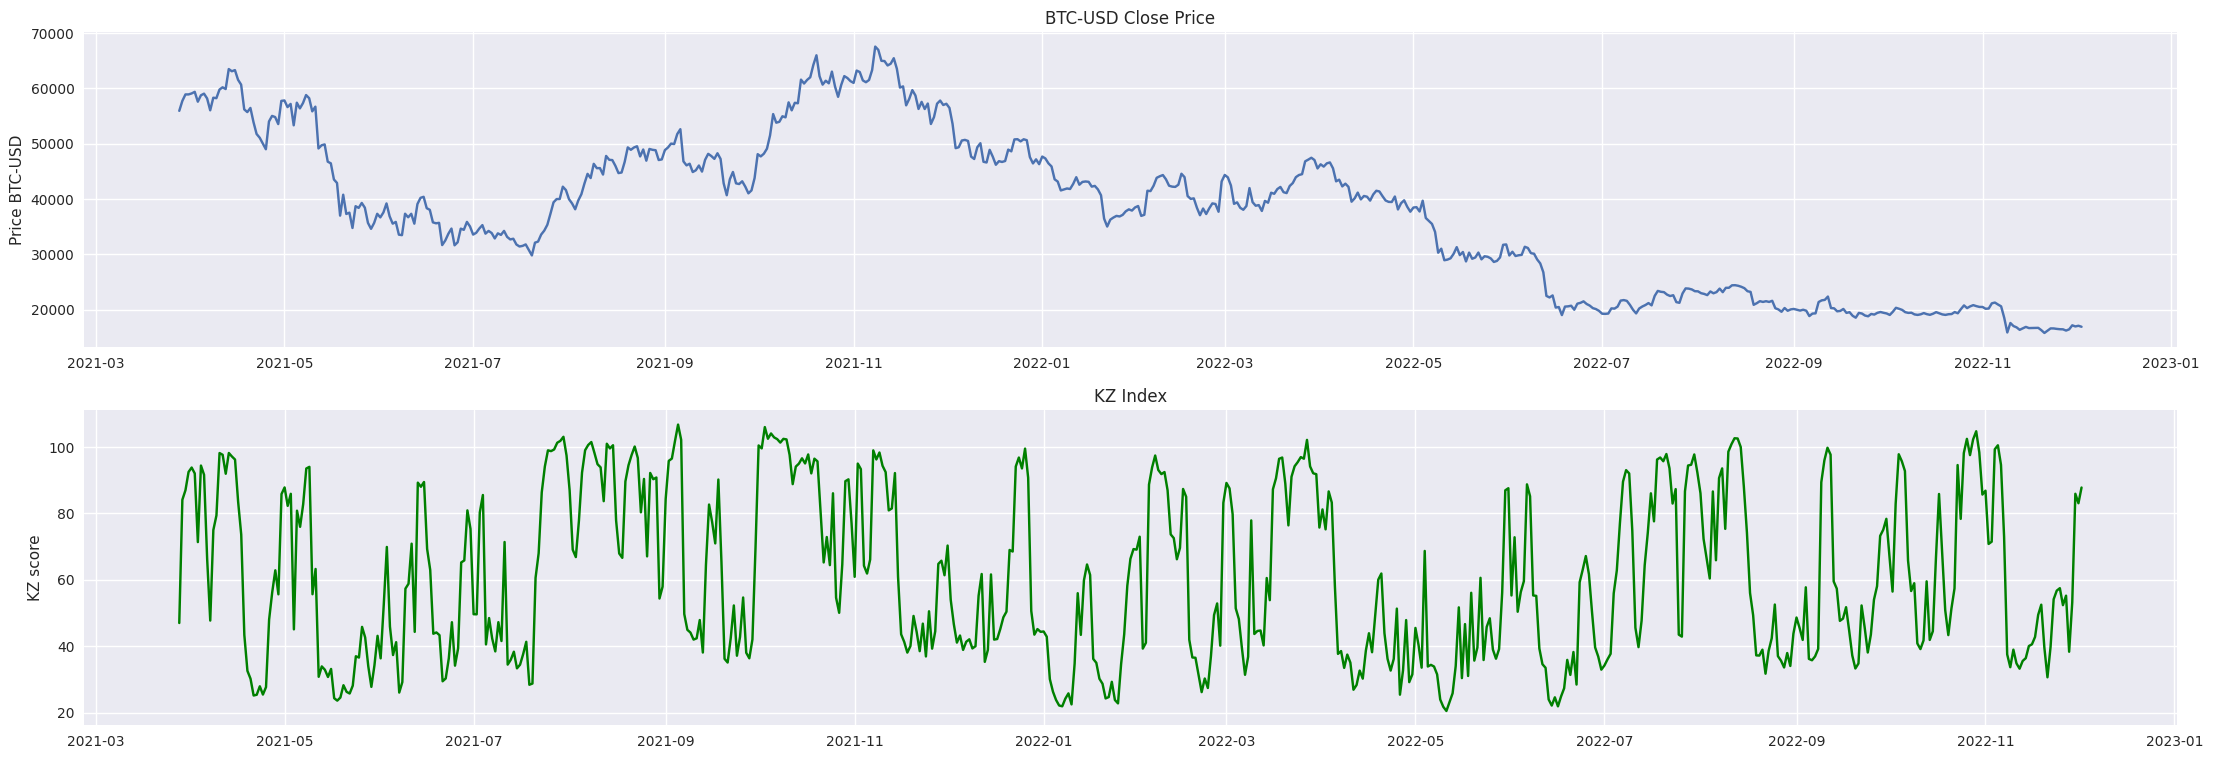

In [43]:
kz = ext_df.kz_score
close = df_price.close

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(27,9))
ax1.plot(close)
ax1.set_ylabel(f'Price {data.symbol}')
ax1.set_title(f'{data.symbol} Close Price')

ax2.plot(kz, color='green')
ax2.set_ylabel('KZ score')
ax2.set_title('KZ Index')

Text(0, 0.5, 'Sentiment Score')

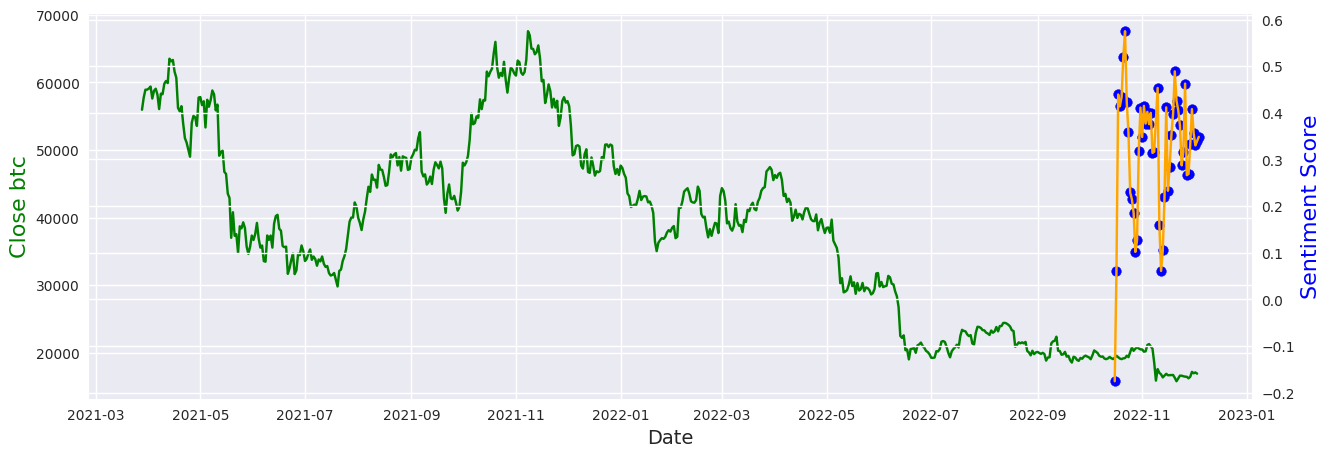

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_price.index, df_price.close, color='green')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel(f'Close {SYMBOL_CUT}', color='green', fontsize=16)

ax2 = ax.twinx()
ax2.scatter(df_result.index, df_result.compound_total, color='blue')
ax2.plot(df_result.index, df_result.compound_total, color='orange')
ax2.set_ylabel('Sentiment Score', color='blue', fontsize=16)

In [45]:
df_price['kz_score'] = ext_df.kz_score
tr_sh = bt.bt_threshold(df_price, 'kz_score', 100, 25)
tr_sh.head()

,entry_time,exit_time,entry_price,exit_price,entry_ind,exit_ind,pnl_percent,pnl_cash
0,2021-05-17,2021-07-28,43537.5117,39995.9062,24.3578,101.3001,-0.0813,917.6539
1,2022-01-05,2022-03-27,43569.0039,46820.4922,23.8357,102.1582,0.0746,991.3648
2,2022-05-09,2022-08-11,30296.9531,23957.5293,23.9598,100.8438,-0.2092,781.1304
